In [1]:
# NAME: Abhijit Hanumeswara Kulkarni
# GITHUB USERNAME: abhijithanumeswarakulkarni
# USC ID: 5367018274

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import os
from collections import defaultdict
from PIL import Image
import random
import shutil
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy

import warnings
warnings.filterwarnings("ignore")

1. Transfer Learning for Image Classification <br />
It is highly recommended that you complete this project using Keras1 and Python. <br />
(a) In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

In [4]:
recycle_repo_path = '/content/drive/MyDrive/DSML_Project/data/RealWaste'
waste_categories = sorted(os.listdir(recycle_repo_path))
print(f"Identified {len(waste_categories)} waste types:\n{waste_categories}")

bin_counts = {}
visual_dims = defaultdict(set)
file_encodings = defaultdict(set)

for waste_type in waste_categories:
    category_path = os.path.join(recycle_repo_path, waste_type)
    bin_items = sorted(os.listdir(category_path))
    bin_counts[waste_type] = len(bin_items)
    for visual_file in bin_items[:5]:
        image_path = os.path.join(category_path, visual_file)
        try:
            with Image.open(image_path) as visual:
                visual_dims[waste_type].add(visual.size)
                file_encodings[waste_type].add(visual.format)
        except Exception as issue:
            print(f"Unreadable image at {image_path}: {issue}")

print("\n📊 Waste Dataset Summary:")
for category in waste_categories:
    print(f"{category}: {bin_counts[category]} images | Shapes: {visual_dims[category]} | Formats: {file_encodings[category]}")

Identified 9 waste types:
['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']

📊 Waste Dataset Summary:
1-Cardboard: 461 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
2-Food Organics: 411 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
3-Glass: 420 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
4-Metal: 790 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
5-Miscellaneous Trash: 495 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
6-Paper: 500 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
7-Plastic: 921 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
8-Textile Trash: 318 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
9-Vegetation: 436 images | Shapes: {(524, 524)} | Formats: {'JPEG'}


(b) Data Exploration and Pre-processing <br />
i. Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.

In [5]:
source_dir = '/content/drive/MyDrive/DSML_Project/data/RealWaste'
train_root = '/content/recycle_trainset'
test_root = '/content/recycle_testset'

for folder in [train_root, test_root]:
    for waste_label in waste_categories:
        os.makedirs(os.path.join(folder, waste_label), exist_ok=True)

for waste_label in waste_categories:
    origin_path = os.path.join(source_dir, waste_label)
    contents = sorted(os.listdir(origin_path))
    random.shuffle(contents)
    cutoff = int(0.8 * len(contents))
    train_files = contents[:cutoff]
    test_files = contents[cutoff:]

    for f in train_files:
        shutil.copyfile(os.path.join(origin_path, f), os.path.join(train_root, waste_label, f))
    for f in test_files:
        shutil.copyfile(os.path.join(origin_path, f), os.path.join(test_root, waste_label, f))

ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [6]:
resize_dim = (224, 224)

def preprocess_folder(source_root, target_root):
    for label_name in waste_categories:
        input_dir = os.path.join(source_root, label_name)
        output_dir = os.path.join(target_root, label_name)
        os.makedirs(output_dir, exist_ok=True)
        for img_file in sorted(os.listdir(input_dir)):
            src_path = os.path.join(input_dir, img_file)
            dst_path = os.path.join(output_dir, img_file)
            try:
                raw = cv2.imread(src_path)
                resized = cv2.resize(raw, resize_dim, interpolation=cv2.INTER_AREA)
                cv2.imwrite(dst_path, resized)
            except:
                pass

preprocess_folder(train_root, '/content/recycle_train_resized')
preprocess_folder(test_root, '/content/recycle_test_resized')

(c) Transfer Learning <br />
i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only
train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted from each image. <br />

(ii) To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV. <br />

(iii) Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization 3, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable. <br />

(iv) iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs. <br />

(v) Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [7]:
augmented_loader = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)

aug_train_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

aug_val_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)

res_eval = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '/content/recycle_test_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

Found 3042 images belonging to 9 classes.
Found 756 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [8]:
base_extractor = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_extractor.layers:
    layer.trainable = False

x = base_extractor.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out_layer = Dense(9, activation='softmax')(x)

res_model = Model(inputs=base_extractor.input, outputs=out_layer)
res_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
checkpoint_path = '/content/best_resnet50_augmented_model.h5'

halt = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
saver = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history_aug_resnet50 = res_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[halt, saver],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2736 - loss: 7.0173

381/381 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - accuracy: 0.2739 - loss: 7.0161 - val_accuracy: 0.5860 - val_loss: 5.8965
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5765 - loss: 5.8982

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.5766 - loss: 5.8979 - val_accuracy: 0.6230 - val_loss: 5.6168
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6490 - loss: 5.4927

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.6490 - loss: 5.4925 - val_accuracy: 0.6415 - val_loss: 5.2957
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6954 - loss: 5.1390

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.6954 - loss: 5.1388 - val_accuracy: 0.6548 - val_loss: 5.0511
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7254 - loss: 4.8067

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7254 - loss: 4.8066 - val_accuracy: 0.6772 - val_loss: 4.7958
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7286 - loss: 4.5753

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7286 - loss: 4.5752 - val_accuracy: 0.6772 - val_loss: 4.5562
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7318 - loss: 4.3154

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7319 - loss: 4.3152 - val_accuracy: 0.6812 - val_loss: 4.3212
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7506 - loss: 4.0943

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7506 - loss: 4.0941 - val_accuracy: 0.6878 - val_loss: 4.0864
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7688 - loss: 3.8502

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7689 - loss: 3.8501 - val_accuracy: 0.6905 - val_loss: 3.8815
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7922 - loss: 3.6007

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.7921 - loss: 3.6006 - val_accuracy: 0.6984 - val_loss: 3.7249
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7976 - loss: 3.4029

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7976 - loss: 3.4028 - val_accuracy: 0.7063 - val_loss: 3.5429
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8129 - loss: 3.1971

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8129 - loss: 3.1971 - val_accuracy: 0.7037 - val_loss: 3.3348
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8063 - loss: 3.0451

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8063 - loss: 3.0450 - val_accuracy: 0.6905 - val_loss: 3.2145
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8151 - loss: 2.8816

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8151 - loss: 2.8815 - val_accuracy: 0.6931 - val_loss: 3.0509
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8279 - loss: 2.7293

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8279 - loss: 2.7292 - val_accuracy: 0.7024 - val_loss: 2.9082
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8398 - loss: 2.5644

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8398 - loss: 2.5643 - val_accuracy: 0.6984 - val_loss: 2.7869
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8477 - loss: 2.4436

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8477 - loss: 2.4436 - val_accuracy: 0.7143 - val_loss: 2.6357
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8334 - loss: 2.3176

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8334 - loss: 2.3176 - val_accuracy: 0.6918 - val_loss: 2.5557
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8249 - loss: 2.2299

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8249 - loss: 2.2298 - val_accuracy: 0.7196 - val_loss: 2.4041
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8531 - loss: 2.1061

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8531 - loss: 2.1061 - val_accuracy: 0.7249 - val_loss: 2.3165
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8652 - loss: 2.0005

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8651 - loss: 2.0005 - val_accuracy: 0.7262 - val_loss: 2.2179
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8610 - loss: 1.9073

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8610 - loss: 1.9073 - val_accuracy: 0.7169 - val_loss: 2.1245
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8449 - loss: 1.8551

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8449 - loss: 1.8551 - val_accuracy: 0.7315 - val_loss: 2.0654
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8687 - loss: 1.7583

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.8687 - loss: 1.7583 - val_accuracy: 0.7434 - val_loss: 2.0043
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8619 - loss: 1.7170

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8619 - loss: 1.7170 - val_accuracy: 0.7249 - val_loss: 1.9588
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8836 - loss: 1.6245

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8836 - loss: 1.6245 - val_accuracy: 0.7262 - val_loss: 1.8829
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8560 - loss: 1.5839

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8560 - loss: 1.5839 - val_accuracy: 0.7341 - val_loss: 1.8555
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8726 - loss: 1.5316

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8726 - loss: 1.5316 - val_accuracy: 0.7447 - val_loss: 1.7874
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8841 - loss: 1.4659

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.8841 - loss: 1.4659 - val_accuracy: 0.7288 - val_loss: 1.7461
Epoch 30/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8826 - loss: 1.4197

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8826 - loss: 1.4198 - val_accuracy: 0.7394 - val_loss: 1.6957
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8789 - loss: 1.4101

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8789 - loss: 1.4101 - val_accuracy: 0.7341 - val_loss: 1.6655
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8796 - loss: 1.3828 - val_accuracy: 0.7156 - val_loss: 1.6947
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8915 - loss: 1.3245

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8915 - loss: 1.3245 - val_accuracy: 0.7341 - val_loss: 1.6115
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8931 - loss: 1.2876

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8931 - loss: 1.2875 - val_accuracy: 0.7474 - val_loss: 1.5852
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8998 - loss: 1.2599 - val_accuracy: 0.7381 - val_loss: 1.6048
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8837 - loss: 1.2558

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8837 - loss: 1.2558 - val_accuracy: 0.7328 - val_loss: 1.5703
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8902 - loss: 1.2273

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8902 - loss: 1.2273 - val_accuracy: 0.7328 - val_loss: 1.5309
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8726 - loss: 1.2305 - val_accuracy: 0.7262 - val_loss: 1.5541
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9024 - loss: 1.1816

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9024 - loss: 1.1816 - val_accuracy: 0.7302 - val_loss: 1.4953
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8969 - loss: 1.1778

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8969 - loss: 1.1778 - val_accuracy: 0.7328 - val_loss: 1.4915
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9031 - loss: 1.1385

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9030 - loss: 1.1386 - val_accuracy: 0.7407 - val_loss: 1.4568
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8939 - loss: 1.1447 - val_accuracy: 0.7328 - val_loss: 1.4776
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9045 - loss: 1.1200

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9045 - loss: 1.1201 - val_accuracy: 0.7434 - val_loss: 1.4506
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8949 - loss: 1.1190 - val_accuracy: 0.7460 - val_loss: 1.4510
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9112 - loss: 1.0891

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9111 - loss: 1.0892 - val_accuracy: 0.7579 - val_loss: 1.4022
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9085 - loss: 1.0886 - val_accuracy: 0.7421 - val_loss: 1.4312
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9001 - loss: 1.0914 - val_accuracy: 0.7500 - val_loss: 1.4090
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9126 - loss: 1.0609 - val_accuracy: 0.7302 - val_loss: 1.4078
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9092 - loss: 1.0596

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9092 - loss: 1.0596 - val_accuracy: 0.7341 - val_loss: 1.3860
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9005 - loss: 1.0644 - val_accuracy: 0.7235 - val_loss: 1.4105
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9096 - loss: 1.0470 - val_accuracy: 0.7302 - val_loss: 1.4221
Epoch 52/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8994 - loss: 1.0564 - val_accuracy: 0.7434 - val_loss: 1.3895
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9106 - loss: 1.0305 - val_accuracy: 0.7368 - val_loss: 1.3899
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9096 - loss: 1.0239

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.9096 - loss: 1.0239 - val_accuracy: 0.7394 - val_loss: 1.3770
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9096 - loss: 1.0289

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9096 - loss: 1.0289 - val_accuracy: 0.7407 - val_loss: 1.3628
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8906 - loss: 1.0526 - val_accuracy: 0.7368 - val_loss: 1.3732
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9150 - loss: 1.0159 - val_accuracy: 0.7288 - val_loss: 1.3660
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9070 - loss: 1.0140 - val_accuracy: 0.7341 - val_loss: 1.3899
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9033 - loss: 1.0190 - val_accuracy: 0.7077 - val_loss: 1.4077
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9009 - loss: 1.0158 - val_accuracy: 0.7315 - val_loss: 1.3888
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9060 - loss: 1.0052 - val_accuracy: 0.7302 - val_loss: 1.3672
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9176 - loss: 

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9176 - loss: 0.9885 - val_accuracy: 0.7487 - val_loss: 1.3351
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9001 - loss: 1.0028 - val_accuracy: 0.7447 - val_loss: 1.3505
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9108 - loss: 1.0137 - val_accuracy: 0.7354 - val_loss: 1.3499
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9101 - loss: 1.0001 - val_accuracy: 0.7394 - val_loss: 1.3458
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9065 - loss: 1.0102 - val_accuracy: 0.7222 - val_loss: 1.3541
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9101 - loss: 0.9884 - val_accuracy: 0.7434 - val_loss: 1.3404
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9025 - loss: 0.9977 - val_accuracy: 0.7407 - val_loss: 1.3571
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9086 - loss

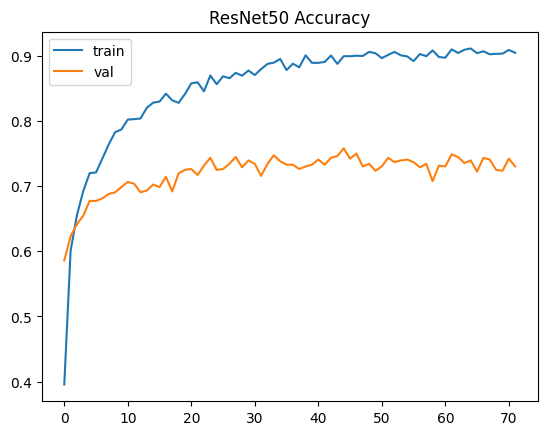

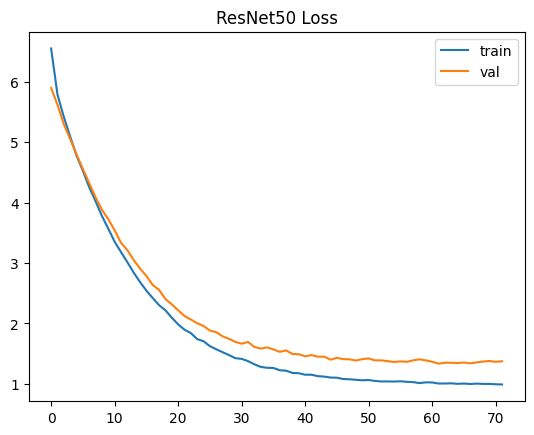

In [10]:
plt.plot(history_aug_resnet50.history['accuracy'], label='train')
plt.plot(history_aug_resnet50.history['val_accuracy'], label='val')
plt.title('ResNet50 Accuracy')
plt.legend()
plt.show()

plt.plot(history_aug_resnet50.history['loss'], label='train')
plt.plot(history_aug_resnet50.history['val_loss'], label='val')
plt.title('ResNet50 Loss')
plt.legend()
plt.show()

In [11]:
# Training set evaluations
train_eval_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow.reset()
true_labels = train_eval_flow.classes
predicted_probs = res_model.predict(train_eval_flow, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=train_eval_flow.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 108ms/step
                       precision    recall  f1-score   support

          1-Cardboard       1.00      1.00      1.00       295
      2-Food Organics       0.98      0.99      0.98       263
              3-Glass       0.97      1.00      0.99       269
              4-Metal       0.99      0.98      0.99       506
5-Miscellaneous Trash       0.97      0.97      0.97       317
              6-Paper       1.00      0.99      0.99       320
            7-Plastic       0.98      0.98      0.98       589
      8-Textile Trash       0.99      0.98      0.98       204
         9-Vegetation       0.99      0.99      0.99       279

             accuracy                           0.99      3042
            macro avg       0.99      0.99      0.99      3042
         weighted avg       0.99      0.99      0.99      3042

Train F1: 0.9864 | Precision: 0.9861 | Recall: 0.9867 | AUC: 0.9998


In [12]:
# Validation set evaluations
aug_eval_flow = aug_val_flow
aug_eval_flow.reset()
true_labels = aug_eval_flow.classes
predicted_probs = res_model.predict(aug_eval_flow, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=aug_eval_flow.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.04      0.03      0.03        73
      2-Food Organics       0.11      0.11      0.11        65
              3-Glass       0.08      0.09      0.09        67
              4-Metal       0.18      0.20      0.19       126
5-Miscellaneous Trash       0.09      0.10      0.09        79
              6-Paper       0.18      0.15      0.16        80
            7-Plastic       0.17      0.16      0.16       147
      8-Textile Trash       0.02      0.02      0.02        50
         9-Vegetation       0.04      0.04      0.04        69

             accuracy                           0.12       756
            macro avg       0.10      0.10      0.10       756
         weighted avg       0.12      0.12      0.11       756

Val F1: 0.0992 | Precision: 0.0999 | Recall: 0.0994 | AUC: 0.5159


In [13]:
# Test set evaluations
res_eval.reset()
true_labels = res_eval.classes
predicted_probs = res_model.predict(res_eval, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)
print(classification_report(true_labels, predicted_labels, target_names=res_eval.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.85      0.90      0.88        93
      2-Food Organics       0.88      0.93      0.90        83
              3-Glass       0.87      0.93      0.90        84
              4-Metal       0.79      0.92      0.85       158
5-Miscellaneous Trash       0.78      0.77      0.78        99
              6-Paper       0.94      0.84      0.89       100
            7-Plastic       0.88      0.75      0.81       185
      8-Textile Trash       0.84      0.83      0.83        64
         9-Vegetation       0.95      0.94      0.95        88

             accuracy                           0.86       954
            macro avg       0.86      0.87      0.86       954
         weighted avg       0.86      0.86      0.86       954

F1: 0.8645 | Precision: 0.8650 | Recall: 0.8675 | AUC: 0.9896


In [14]:
res101_base = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in res101_base.layers:
    layer.trainable = False

z = res101_base.output
z = GlobalAveragePooling2D()(z)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)
z = Dense(256, activation='relu', kernel_regularizer='l2')(z)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)
res101_out = Dense(9, activation='softmax')(z)

res101_model = Model(inputs=res101_base.input, outputs=res101_out)
res101_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
res101_ckpt = '/content/best_resnet101_augmented_model.h5'

early_stop_101 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_101 = ModelCheckpoint(filepath=res101_ckpt, monitor='val_loss', save_best_only=True)

res101_history = res101_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[early_stop_101, model_save_101],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2817 - loss: 6.9212

381/381 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.2821 - loss: 6.9201 - val_accuracy: 0.5860 - val_loss: 5.8965
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5775 - loss: 5.8459

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.5775 - loss: 5.8457 - val_accuracy: 0.6164 - val_loss: 5.5980
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6466 - loss: 5.4694

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.6467 - loss: 5.4693 - val_accuracy: 0.6389 - val_loss: 5.3235
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6807 - loss: 5.1541

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.6807 - loss: 5.1538 - val_accuracy: 0.6640 - val_loss: 5.0425
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7255 - loss: 4.8239

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7255 - loss: 4.8238 - val_accuracy: 0.6812 - val_loss: 4.8003
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7321 - loss: 4.5791

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7321 - loss: 4.5790 - val_accuracy: 0.6958 - val_loss: 4.5372
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7424 - loss: 4.3237

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.7424 - loss: 4.3235 - val_accuracy: 0.6944 - val_loss: 4.2961
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7647 - loss: 4.0584

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7647 - loss: 4.0583 - val_accuracy: 0.7209 - val_loss: 4.0628
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7778 - loss: 3.8465

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7778 - loss: 3.8464 - val_accuracy: 0.7077 - val_loss: 3.8462
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7997 - loss: 3.6143

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7997 - loss: 3.6142 - val_accuracy: 0.7090 - val_loss: 3.6699
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7906 - loss: 3.4295

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7906 - loss: 3.4293 - val_accuracy: 0.7183 - val_loss: 3.4622
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7999 - loss: 3.2446

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7999 - loss: 3.2445 - val_accuracy: 0.7288 - val_loss: 3.3105
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7975 - loss: 3.0832

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.7975 - loss: 3.0831 - val_accuracy: 0.7249 - val_loss: 3.1409
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8249 - loss: 2.8838

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8248 - loss: 2.8837 - val_accuracy: 0.7447 - val_loss: 2.9987
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8078 - loss: 2.7689

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8078 - loss: 2.7688 - val_accuracy: 0.7130 - val_loss: 2.8979
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8233 - loss: 2.5978

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8233 - loss: 2.5977 - val_accuracy: 0.7222 - val_loss: 2.7470
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8565 - loss: 2.4274

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8565 - loss: 2.4274 - val_accuracy: 0.7328 - val_loss: 2.6053
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8364 - loss: 2.3541

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8364 - loss: 2.3540 - val_accuracy: 0.7288 - val_loss: 2.5138
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8522 - loss: 2.2221

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.8522 - loss: 2.2220 - val_accuracy: 0.7381 - val_loss: 2.3934
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8299 - loss: 2.1731

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8299 - loss: 2.1730 - val_accuracy: 0.7275 - val_loss: 2.3266
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8517 - loss: 2.0351

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8517 - loss: 2.0350 - val_accuracy: 0.7315 - val_loss: 2.2469
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8597 - loss: 1.9418

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8597 - loss: 1.9418 - val_accuracy: 0.7262 - val_loss: 2.1718
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8566 - loss: 1.8655

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8565 - loss: 1.8655 - val_accuracy: 0.7302 - val_loss: 2.0777
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8552 - loss: 1.7953

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8552 - loss: 1.7953 - val_accuracy: 0.7341 - val_loss: 2.0209
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8760 - loss: 1.6982

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8760 - loss: 1.6982 - val_accuracy: 0.7487 - val_loss: 1.9565
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8787 - loss: 1.6487

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8786 - loss: 1.6487 - val_accuracy: 0.7540 - val_loss: 1.8846
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8598 - loss: 1.6194

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8598 - loss: 1.6194 - val_accuracy: 0.7262 - val_loss: 1.8793
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8711 - loss: 1.5586

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.8711 - loss: 1.5586 - val_accuracy: 0.7394 - val_loss: 1.8307
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8821 - loss: 1.4937

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8821 - loss: 1.4937 - val_accuracy: 0.7500 - val_loss: 1.7470
Epoch 30/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8826 - loss: 1.4586

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8826 - loss: 1.4586 - val_accuracy: 0.7394 - val_loss: 1.7111
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8800 - loss: 1.4298

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8799 - loss: 1.4298 - val_accuracy: 0.7487 - val_loss: 1.6826
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8897 - loss: 1.3780

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8897 - loss: 1.3780 - val_accuracy: 0.7460 - val_loss: 1.6436
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8964 - loss: 1.3349

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.8963 - loss: 1.3349 - val_accuracy: 0.7421 - val_loss: 1.6064
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8828 - loss: 1.3114

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8828 - loss: 1.3114 - val_accuracy: 0.7434 - val_loss: 1.5974
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8966 - loss: 1.2733

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8966 - loss: 1.2733 - val_accuracy: 0.7672 - val_loss: 1.5235
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8833 - loss: 1.2719 - val_accuracy: 0.7500 - val_loss: 1.5476
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.8870 - loss: 1.2546 - val_accuracy: 0.7381 - val_loss: 1.5291
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8959 - loss: 1.2095

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8959 - loss: 1.2095 - val_accuracy: 0.7341 - val_loss: 1.5165
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.9058 - loss: 1.1822 - val_accuracy: 0.7222 - val_loss: 1.5182
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8956 - loss: 1.1842

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.8956 - loss: 1.1842 - val_accuracy: 0.7302 - val_loss: 1.4722
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8981 - loss: 1.1679

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.8981 - loss: 1.1679 - val_accuracy: 0.7368 - val_loss: 1.4629
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8989 - loss: 1.1363

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.8989 - loss: 1.1363 - val_accuracy: 0.7394 - val_loss: 1.4403
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8896 - loss: 1.1432

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8896 - loss: 1.1432 - val_accuracy: 0.7553 - val_loss: 1.4359
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8778 - loss: 1.1505

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8778 - loss: 1.1505 - val_accuracy: 0.7500 - val_loss: 1.4039
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8984 - loss: 1.1117 - val_accuracy: 0.7513 - val_loss: 1.4043
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9132 - loss: 1.0797 - val_accuracy: 0.7460 - val_loss: 1.4073
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8897 - loss: 1.1190 - val_accuracy: 0.7394 - val_loss: 1.4142
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8944 - loss: 1.0917

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8944 - loss: 1.0917 - val_accuracy: 0.7354 - val_loss: 1.3995
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9021 - loss: 1.0726

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9021 - loss: 1.0727 - val_accuracy: 0.7407 - val_loss: 1.3558
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9077 - loss: 1.0516 - val_accuracy: 0.7381 - val_loss: 1.3775
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8999 - loss: 1.0569 - val_accuracy: 0.7421 - val_loss: 1.3721
Epoch 52/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.9086 - loss: 1.0509 - val_accuracy: 0.7354 - val_loss: 1.3843
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9046 - loss: 1.0326 - val_accuracy: 0.7262 - val_loss: 1.3636
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9015 - loss: 1.0474

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9015 - loss: 1.0474 - val_accuracy: 0.7474 - val_loss: 1.3504
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9039 - loss: 1.0484

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9039 - loss: 1.0484 - val_accuracy: 0.7354 - val_loss: 1.3366
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9076 - loss: 1.0348

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9076 - loss: 1.0348 - val_accuracy: 0.7540 - val_loss: 1.3264
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9113 - loss: 1.0100 - val_accuracy: 0.7407 - val_loss: 1.3365
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8936 - loss: 1.0356

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8936 - loss: 1.0356 - val_accuracy: 0.7474 - val_loss: 1.3257
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8928 - loss: 1.0376 - val_accuracy: 0.7447 - val_loss: 1.3332
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9074 - loss: 1.0086

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9074 - loss: 1.0087 - val_accuracy: 0.7513 - val_loss: 1.3239
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.9175 - loss: 1.0156 - val_accuracy: 0.7487 - val_loss: 1.3242
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8948 - loss: 1.0276

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.8949 - loss: 1.0276 - val_accuracy: 0.7487 - val_loss: 1.3073
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8995 - loss: 1.0149

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.8995 - loss: 1.0149 - val_accuracy: 0.7646 - val_loss: 1.2911
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9217 - loss: 0.9912

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9216 - loss: 0.9913 - val_accuracy: 0.7553 - val_loss: 1.2907
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8871 - loss: 1.0349 - val_accuracy: 0.7341 - val_loss: 1.3516
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9026 - loss: 1.0150 - val_accuracy: 0.7778 - val_loss: 1.2923
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9025 - loss: 1.0013 - val_accuracy: 0.7712 - val_loss: 1.3025
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9160 - loss: 0.9936 - val_accuracy: 0.7632 - val_loss: 1.2909
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9068 - loss: 0.9994 - val_accuracy: 0.7474 - val_loss: 1.3308
Epoch 70/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9127 - loss: 0.9966 - val_accuracy: 0.7500 - val_loss: 1.3122
Epoch 71/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9002 - loss

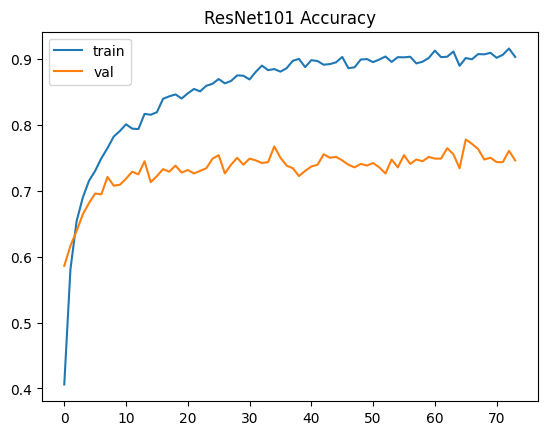

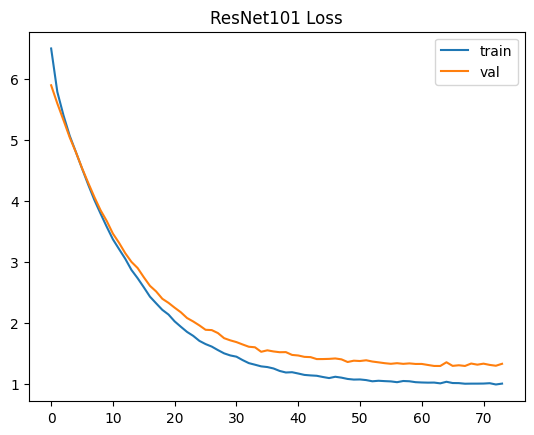

In [16]:
plt.plot(res101_history.history['accuracy'], label='train')
plt.plot(res101_history.history['val_accuracy'], label='val')
plt.title('ResNet101 Accuracy')
plt.legend()
plt.show()

plt.plot(res101_history.history['loss'], label='train')
plt.plot(res101_history.history['val_loss'], label='val')
plt.title('ResNet101 Loss')
plt.legend()
plt.show()

In [17]:
# Train set evaluations
train_eval_flow_101 = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow_101.reset()
true_labels_101 = train_eval_flow_101.classes
predicted_probs_101 = res101_model.predict(train_eval_flow_101, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=train_eval_flow_101.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_labels_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_labels_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step
                       precision    recall  f1-score   support

          1-Cardboard       1.00      0.99      0.99       295
      2-Food Organics       0.99      1.00      0.99       263
              3-Glass       0.99      0.99      0.99       269
              4-Metal       0.99      0.98      0.98       506
5-Miscellaneous Trash       0.99      0.98      0.99       317
              6-Paper       0.99      0.99      0.99       320
            7-Plastic       0.97      0.99      0.98       589
      8-Textile Trash       1.00      1.00      1.00       204
         9-Vegetation       1.00      0.99      0.99       279

             accuracy                           0.99      3042
            macro avg       0.99      0.99      0.99      3042
         weighted avg       0.99      0.99      0.99      3042

Train F1: 0.9903 | Precision: 0.9909 | Recall: 0.9898 | AUC: 0.9999


In [18]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_101 = aug_val_flow.classes
predicted_probs_101 = res101_model.predict(aug_val_flow, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=aug_val_flow.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.10      0.07      0.08        73
      2-Food Organics       0.13      0.14      0.13        65
              3-Glass       0.09      0.09      0.09        67
              4-Metal       0.26      0.28      0.27       126
5-Miscellaneous Trash       0.11      0.10      0.10        79
              6-Paper       0.11      0.11      0.11        80
            7-Plastic       0.15      0.15      0.15       147
      8-Textile Trash       0.12      0.14      0.13        50
         9-Vegetation       0.10      0.10      0.10        69

             accuracy                           0.14       756
            macro avg       0.13      0.13      0.13       756
         weighted avg       0.14      0.14      0.14       756

Val F1: 0.1295 | Precision: 0.1290 | Recall: 0.1310 | AUC: 0.5198


In [19]:
# Test set evaluations
res_eval.reset()
true_labels_101 = res_eval.classes
predicted_probs_101 = res101_model.predict(res_eval, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=res_eval.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.82      0.86      0.84        93
      2-Food Organics       0.95      0.90      0.93        83
              3-Glass       0.93      0.89      0.91        84
              4-Metal       0.82      0.92      0.87       158
5-Miscellaneous Trash       0.81      0.77      0.79        99
              6-Paper       0.93      0.87      0.90       100
            7-Plastic       0.88      0.80      0.84       185
      8-Textile Trash       0.81      0.94      0.87        64
         9-Vegetation       0.96      0.97      0.96        88

             accuracy                           0.87       954
            macro avg       0.88      0.88      0.88       954
         weighted avg       0.87      0.87      0.87       954

F1: 0.8768 | Precision: 0.8768 | Recall: 0.8795 | AUC: 0.9883


In [20]:
# EfficientNetB0
eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in eff_base.layers:
    layer.trainable = False

e = eff_base.output
e = GlobalAveragePooling2D()(e)
e = BatchNormalization()(e)
e = Dropout(0.3)(e)
e = Dense(256, activation='relu', kernel_regularizer='l2')(e)
e = BatchNormalization()(e)
e = Dropout(0.3)(e)
eff_out = Dense(9, activation='softmax')(e)

eff_model = Model(inputs=eff_base.input, outputs=eff_out)
eff_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
eff_ckpt = '/content/best_efficientnetb0_augmented_model.h5'

early_stop_eff = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_eff = ModelCheckpoint(filepath=eff_ckpt, monitor='val_loss', save_best_only=True)

eff_history = eff_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[early_stop_eff, model_save_eff],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2255 - loss: 6.9582

381/381 ━━━━━━━━━━━━━━━━━━━━ 99s 192ms/step - accuracy: 0.2257 - loss: 6.9572 - val_accuracy: 0.4974 - val_loss: 5.8023
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4593 - loss: 5.9283

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.4593 - loss: 5.9281 - val_accuracy: 0.5529 - val_loss: 5.5162
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5143 - loss: 5.5577

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.5144 - loss: 5.5575 - val_accuracy: 0.5688 - val_loss: 5.2501
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5593 - loss: 5.2404

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.5593 - loss: 5.2403 - val_accuracy: 0.5794 - val_loss: 5.0362
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5829 - loss: 5.0343

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.5829 - loss: 5.0340 - val_accuracy: 0.6098 - val_loss: 4.7928
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5923 - loss: 4.7685

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.5924 - loss: 4.7683 - val_accuracy: 0.6230 - val_loss: 4.5961
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6289 - loss: 4.5310

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.6289 - loss: 4.5308 - val_accuracy: 0.6283 - val_loss: 4.4236
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6292 - loss: 4.3173

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6292 - loss: 4.3172 - val_accuracy: 0.6310 - val_loss: 4.2295
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6415 - loss: 4.1317

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6415 - loss: 4.1316 - val_accuracy: 0.6270 - val_loss: 4.0952
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6713 - loss: 3.9480

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6713 - loss: 3.9479 - val_accuracy: 0.6283 - val_loss: 3.9081
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6345 - loss: 3.8116

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.6346 - loss: 3.8114 - val_accuracy: 0.6495 - val_loss: 3.7127
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7066 - loss: 3.5478

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7066 - loss: 3.5478 - val_accuracy: 0.6548 - val_loss: 3.6056
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6964 - loss: 3.4331

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.6965 - loss: 3.4330 - val_accuracy: 0.6336 - val_loss: 3.4469
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6936 - loss: 3.2847

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6936 - loss: 3.2846 - val_accuracy: 0.6468 - val_loss: 3.3319
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7089 - loss: 3.1455

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7088 - loss: 3.1455 - val_accuracy: 0.6653 - val_loss: 3.1717
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6815 - loss: 3.0672

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6816 - loss: 3.0671 - val_accuracy: 0.6561 - val_loss: 3.0878
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7118 - loss: 2.8835

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7118 - loss: 2.8834 - val_accuracy: 0.6548 - val_loss: 2.9732
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7201 - loss: 2.7830

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7201 - loss: 2.7830 - val_accuracy: 0.6653 - val_loss: 2.8394
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7393 - loss: 2.6483

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7392 - loss: 2.6483 - val_accuracy: 0.6720 - val_loss: 2.7138
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7354 - loss: 2.5657

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.7354 - loss: 2.5656 - val_accuracy: 0.6640 - val_loss: 2.6684
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7341 - loss: 2.4812

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7341 - loss: 2.4812 - val_accuracy: 0.6706 - val_loss: 2.5838
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7526 - loss: 2.3687

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7525 - loss: 2.3687 - val_accuracy: 0.6548 - val_loss: 2.5268
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7368 - loss: 2.2957

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7368 - loss: 2.2957 - val_accuracy: 0.6601 - val_loss: 2.4606
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7095 - loss: 2.2990

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7096 - loss: 2.2988 - val_accuracy: 0.6812 - val_loss: 2.3456
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7496 - loss: 2.1657

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7496 - loss: 2.1656 - val_accuracy: 0.6627 - val_loss: 2.3313
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7506 - loss: 2.0816

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7506 - loss: 2.0816 - val_accuracy: 0.6667 - val_loss: 2.2627
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7513 - loss: 2.0431

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7513 - loss: 2.0430 - val_accuracy: 0.6799 - val_loss: 2.1620
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7634 - loss: 1.9562

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7634 - loss: 1.9562 - val_accuracy: 0.6481 - val_loss: 2.1435
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7597 - loss: 1.9238

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7596 - loss: 1.9238 - val_accuracy: 0.6865 - val_loss: 2.0792
Epoch 30/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7572 - loss: 1.8709

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7572 - loss: 1.8709 - val_accuracy: 0.6812 - val_loss: 2.0457
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7554 - loss: 1.8360

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.7555 - loss: 1.8359 - val_accuracy: 0.6746 - val_loss: 2.0299
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7611 - loss: 1.8020

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7611 - loss: 1.8019 - val_accuracy: 0.6852 - val_loss: 1.9386
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7536 - loss: 1.7733 - val_accuracy: 0.6825 - val_loss: 1.9452
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7650 - loss: 1.7150

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7649 - loss: 1.7151 - val_accuracy: 0.6720 - val_loss: 1.8729
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7690 - loss: 1.6606

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7690 - loss: 1.6606 - val_accuracy: 0.7116 - val_loss: 1.8396
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7700 - loss: 1.6366

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7700 - loss: 1.6366 - val_accuracy: 0.6772 - val_loss: 1.8085
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7628 - loss: 1.6239 - val_accuracy: 0.6931 - val_loss: 1.8088
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7800 - loss: 1.5721

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.7800 - loss: 1.5721 - val_accuracy: 0.6839 - val_loss: 1.7711
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7816 - loss: 1.5342 - val_accuracy: 0.6720 - val_loss: 1.7863
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7841 - loss: 1.5241

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7841 - loss: 1.5241 - val_accuracy: 0.6772 - val_loss: 1.7589
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7648 - loss: 1.5131

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7649 - loss: 1.5131 - val_accuracy: 0.6931 - val_loss: 1.7064
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7821 - loss: 1.4802

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7821 - loss: 1.4802 - val_accuracy: 0.6905 - val_loss: 1.6877
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7896 - loss: 1.4671

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7896 - loss: 1.4671 - val_accuracy: 0.6799 - val_loss: 1.6815
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7885 - loss: 1.4362 - val_accuracy: 0.6733 - val_loss: 1.7002
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7887 - loss: 1.4077

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.7887 - loss: 1.4077 - val_accuracy: 0.6772 - val_loss: 1.6776
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7867 - loss: 1.4151

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7867 - loss: 1.4151 - val_accuracy: 0.6825 - val_loss: 1.6214
Epoch 47/100
380/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7880 - loss: 1.3921

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7880 - loss: 1.3921 - val_accuracy: 0.6958 - val_loss: 1.5989
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7695 - loss: 1.3889

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.7696 - loss: 1.3889 - val_accuracy: 0.6865 - val_loss: 1.5824
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7987 - loss: 1.3450 - val_accuracy: 0.6812 - val_loss: 1.6155
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8010 - loss: 1.3452 - val_accuracy: 0.6759 - val_loss: 1.5908
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7888 - loss: 1.3398

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7888 - loss: 1.3398 - val_accuracy: 0.6852 - val_loss: 1.5783
Epoch 52/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8077 - loss: 1.3171

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8077 - loss: 1.3172 - val_accuracy: 0.6984 - val_loss: 1.5540
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7957 - loss: 1.2932

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7957 - loss: 1.2933 - val_accuracy: 0.6746 - val_loss: 1.5446
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7927 - loss: 1.3116

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7927 - loss: 1.3116 - val_accuracy: 0.6892 - val_loss: 1.5396
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7967 - loss: 1.2983

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7967 - loss: 1.2983 - val_accuracy: 0.6839 - val_loss: 1.5176
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8062 - loss: 1.2714 - val_accuracy: 0.6905 - val_loss: 1.5406
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8044 - loss: 1.2400

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8043 - loss: 1.2401 - val_accuracy: 0.7130 - val_loss: 1.5004
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8079 - loss: 1.2510 - val_accuracy: 0.6640 - val_loss: 1.5281
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8111 - loss: 1.2465 - val_accuracy: 0.6812 - val_loss: 1.5240
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8031 - loss: 1.2262 - val_accuracy: 0.6944 - val_loss: 1.5050
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.8122 - loss: 1.2296 - val_accuracy: 0.6892 - val_loss: 1.5115
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8088 - loss: 1.2334 - val_accuracy: 0.6799 - val_loss: 1.5147
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7917 - loss: 1.2369 - val_accuracy: 0.6812 - val_loss: 1.5066
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8064 - loss: 

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8063 - loss: 1.2227 - val_accuracy: 0.7063 - val_loss: 1.4580
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7912 - loss: 1.2555 - val_accuracy: 0.6852 - val_loss: 1.4661
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8132 - loss: 1.1970 - val_accuracy: 0.6825 - val_loss: 1.4780
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8011 - loss: 1.2113 - val_accuracy: 0.6905 - val_loss: 1.4625
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8149 - loss: 1.1906

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8149 - loss: 1.1906 - val_accuracy: 0.6971 - val_loss: 1.4561
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8054 - loss: 1.2268 - val_accuracy: 0.6786 - val_loss: 1.4828
Epoch 70/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8023 - loss: 1.2161 - val_accuracy: 0.7011 - val_loss: 1.4771
Epoch 71/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7977 - loss: 1.2200

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7977 - loss: 1.2200 - val_accuracy: 0.6997 - val_loss: 1.4555
Epoch 72/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8220 - loss: 1.1806 - val_accuracy: 0.6839 - val_loss: 1.4896
Epoch 73/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8064 - loss: 1.2022 - val_accuracy: 0.6892 - val_loss: 1.4724
Epoch 74/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8077 - loss: 1.1883 - val_accuracy: 0.7063 - val_loss: 1.4583
Epoch 75/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8221 - loss: 1.1613

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8221 - loss: 1.1613 - val_accuracy: 0.6865 - val_loss: 1.4400
Epoch 76/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8281 - loss: 1.1577

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8281 - loss: 1.1578 - val_accuracy: 0.7063 - val_loss: 1.4363
Epoch 77/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8038 - loss: 1.1904 - val_accuracy: 0.6984 - val_loss: 1.4385
Epoch 78/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8222 - loss: 1.1574

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.8222 - loss: 1.1575 - val_accuracy: 0.7037 - val_loss: 1.4120
Epoch 79/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.8259 - loss: 1.1551 - val_accuracy: 0.6865 - val_loss: 1.4496
Epoch 80/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8153 - loss: 1.1684

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8152 - loss: 1.1684 - val_accuracy: 0.7063 - val_loss: 1.4076
Epoch 81/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.8037 - loss: 1.1869 - val_accuracy: 0.6984 - val_loss: 1.4216
Epoch 82/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8215 - loss: 1.1493 - val_accuracy: 0.7050 - val_loss: 1.4195
Epoch 83/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8212 - loss: 1.1557 - val_accuracy: 0.7077 - val_loss: 1.4204
Epoch 84/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8241 - loss: 1.1724 - val_accuracy: 0.7037 - val_loss: 1.4208
Epoch 85/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8237 - loss: 1.1531

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8237 - loss: 1.1531 - val_accuracy: 0.7196 - val_loss: 1.3877
Epoch 86/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8096 - loss: 1.1744 - val_accuracy: 0.7037 - val_loss: 1.4209
Epoch 87/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8246 - loss: 1.1478 - val_accuracy: 0.7037 - val_loss: 1.4068
Epoch 88/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8278 - loss: 1.1396 - val_accuracy: 0.7103 - val_loss: 1.4210
Epoch 89/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8019 - loss: 1.1841 - val_accuracy: 0.7288 - val_loss: 1.3955
Epoch 90/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.8161 - loss: 1.1615 - val_accuracy: 0.7077 - val_loss: 1.4176
Epoch 91/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8133 - loss: 1.1510 - val_accuracy: 0.6693 - val_loss: 1.4388
Epoch 92/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8149 - loss

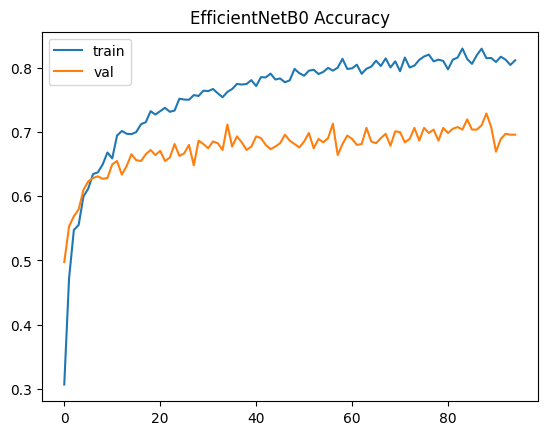

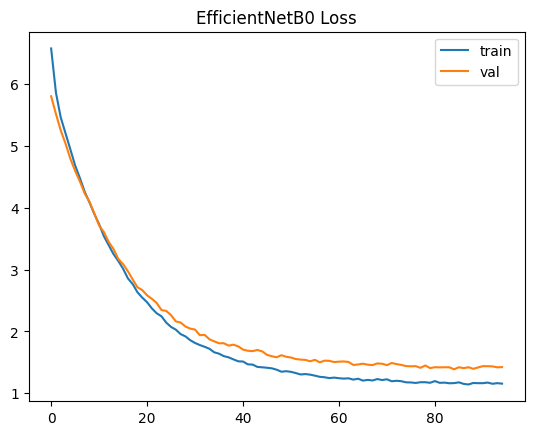

In [22]:
plt.plot(eff_history.history['accuracy'], label='train')
plt.plot(eff_history.history['val_accuracy'], label='val')
plt.title('EfficientNetB0 Accuracy')
plt.legend()
plt.show()

plt.plot(eff_history.history['loss'], label='train')
plt.plot(eff_history.history['val_loss'], label='val')
plt.title('EfficientNetB0 Loss')
plt.legend()
plt.show()

In [23]:
# Train set evaluations
train_eval_flow_eff = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow_eff.reset()
true_labels_eff = train_eval_flow_eff.classes
predicted_probs_eff = eff_model.predict(train_eval_flow_eff, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)

print(classification_report(true_labels_eff, predicted_labels_eff, target_names=train_eval_flow_eff.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.99      0.98      0.98       295
      2-Food Organics       0.93      0.98      0.95       263
              3-Glass       0.97      0.98      0.98       269
              4-Metal       0.94      0.97      0.96       506
5-Miscellaneous Trash       0.96      0.89      0.92       317
              6-Paper       0.97      0.98      0.97       320
            7-Plastic       0.97      0.96      0.96       589
      8-Textile Trash       0.95      0.95      0.95       204
         9-Vegetation       0.99      0.97      0.98       279

             accuracy                           0.96      3042
            macro avg       0.96      0.96      0.96      3042
         weighted avg       0.96      0.96      0.96      3042

Train F1: 0.9624 | Precision: 0.9630 | Recall: 0.9623 | AUC: 0.9987


In [24]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_eff = aug_val_flow.classes
predicted_probs_eff = eff_model.predict(aug_val_flow, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)

print(classification_report(true_labels_eff, predicted_labels_eff, target_names=aug_val_flow.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.17      0.10      0.12        73
      2-Food Organics       0.08      0.08      0.08        65
              3-Glass       0.10      0.10      0.10        67
              4-Metal       0.17      0.20      0.18       126
5-Miscellaneous Trash       0.11      0.10      0.10        79
              6-Paper       0.07      0.07      0.07        80
            7-Plastic       0.18      0.16      0.17       147
      8-Textile Trash       0.08      0.12      0.10        50
         9-Vegetation       0.08      0.09      0.09        69

             accuracy                           0.12       756
            macro avg       0.12      0.11      0.11       756
         weighted avg       0.13      0.12      0.12       756

Val F1: 0.1131 | Precision: 0.1161 | Recall: 0.1136 | AUC: 0.5127


In [25]:
# Test set evaluations
res_eval.reset()
true_labels_eff = res_eval.classes
predicted_probs_eff = eff_model.predict(res_eval, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)
print(classification_report(true_labels_eff, predicted_labels_eff, target_names=res_eval.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.79      0.80      0.79        93
      2-Food Organics       0.77      0.90      0.83        83
              3-Glass       0.83      0.75      0.79        84
              4-Metal       0.73      0.81      0.77       158
5-Miscellaneous Trash       0.73      0.67      0.69        99
              6-Paper       0.87      0.87      0.87       100
            7-Plastic       0.81      0.72      0.77       185
      8-Textile Trash       0.81      0.81      0.81        64
         9-Vegetation       0.91      0.94      0.93        88

             accuracy                           0.80       954
            macro avg       0.81      0.81      0.81       954
         weighted avg       0.80      0.80      0.80       954

F1: 0.8055 | Precision: 0.8054 | Recall: 0.8085 | AUC: 0.9775


In [26]:
# VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers:
    layer.trainable = False

v = vgg_base.output
v = GlobalAveragePooling2D()(v)
v = BatchNormalization()(v)
v = Dropout(0.3)(v)
v = Dense(256, activation='relu', kernel_regularizer='l2')(v)
v = BatchNormalization()(v)
v = Dropout(0.3)(v)
vgg_out = Dense(9, activation='softmax', kernel_regularizer='l2')(v)

vgg_model = Model(inputs=vgg_base.input, outputs=vgg_out)
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [27]:
vgg_ckpt = '/content/best_vgg16_augmented_model.h5'

early_stop_vgg = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_vgg = ModelCheckpoint(filepath=vgg_ckpt, monitor='val_loss', save_best_only=True)

vgg_history = vgg_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[early_stop_vgg, model_save_vgg],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1680 - loss: 6.3972

381/381 ━━━━━━━━━━━━━━━━━━━━ 55s 132ms/step - accuracy: 0.1682 - loss: 6.3963 - val_accuracy: 0.4325 - val_loss: 5.3519
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3741 - loss: 5.4819

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3742 - loss: 5.4815 - val_accuracy: 0.5132 - val_loss: 5.0507
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4629 - loss: 5.0789

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4630 - loss: 5.0786 - val_accuracy: 0.5608 - val_loss: 4.8007
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5261 - loss: 4.8243

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.5261 - loss: 4.8241 - val_accuracy: 0.5622 - val_loss: 4.6461
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5507 - loss: 4.5431

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.5507 - loss: 4.5429 - val_accuracy: 0.6032 - val_loss: 4.4297
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5696 - loss: 4.3701

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.5697 - loss: 4.3700 - val_accuracy: 0.6124 - val_loss: 4.2507
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5981 - loss: 4.1805

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.5981 - loss: 4.1804 - val_accuracy: 0.6389 - val_loss: 4.0777
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6258 - loss: 3.9755

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6258 - loss: 3.9754 - val_accuracy: 0.6310 - val_loss: 3.9450
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6437 - loss: 3.8144

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6437 - loss: 3.8143 - val_accuracy: 0.6217 - val_loss: 3.8030
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6418 - loss: 3.6425

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6418 - loss: 3.6424 - val_accuracy: 0.6310 - val_loss: 3.6461
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6612 - loss: 3.5264

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6612 - loss: 3.5263 - val_accuracy: 0.6481 - val_loss: 3.5143
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6721 - loss: 3.3816

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6721 - loss: 3.3816 - val_accuracy: 0.6270 - val_loss: 3.4160
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6678 - loss: 3.2486

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6678 - loss: 3.2485 - val_accuracy: 0.6336 - val_loss: 3.2917
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6877 - loss: 3.1210

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6877 - loss: 3.1210 - val_accuracy: 0.6389 - val_loss: 3.1772
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6734 - loss: 3.0214

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6734 - loss: 3.0212 - val_accuracy: 0.6548 - val_loss: 3.0567
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7045 - loss: 2.8698

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7045 - loss: 2.8698 - val_accuracy: 0.6336 - val_loss: 2.9726
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7037 - loss: 2.8007

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7037 - loss: 2.8005 - val_accuracy: 0.6376 - val_loss: 2.8627
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7004 - loss: 2.6783

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7005 - loss: 2.6782 - val_accuracy: 0.6429 - val_loss: 2.7968
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7192 - loss: 2.5833

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7192 - loss: 2.5832 - val_accuracy: 0.6455 - val_loss: 2.7188
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7217 - loss: 2.4780

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7217 - loss: 2.4780 - val_accuracy: 0.6508 - val_loss: 2.6158
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7268 - loss: 2.4037

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7268 - loss: 2.4037 - val_accuracy: 0.6601 - val_loss: 2.5332
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7161 - loss: 2.3417

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.7161 - loss: 2.3416 - val_accuracy: 0.6653 - val_loss: 2.4436
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7221 - loss: 2.2709

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7222 - loss: 2.2709 - val_accuracy: 0.6640 - val_loss: 2.3713
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7464 - loss: 2.1589

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7464 - loss: 2.1589 - val_accuracy: 0.6706 - val_loss: 2.3042
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7350 - loss: 2.1272

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7350 - loss: 2.1271 - val_accuracy: 0.6693 - val_loss: 2.2658
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7344 - loss: 2.0578

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.7344 - loss: 2.0578 - val_accuracy: 0.6640 - val_loss: 2.2132
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7359 - loss: 2.0031

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7359 - loss: 2.0030 - val_accuracy: 0.6574 - val_loss: 2.1690
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7564 - loss: 1.9323

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7564 - loss: 1.9323 - val_accuracy: 0.6680 - val_loss: 2.1178
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7471 - loss: 1.8941

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7471 - loss: 1.8941 - val_accuracy: 0.6601 - val_loss: 2.0532
Epoch 30/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7553 - loss: 1.8432

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7553 - loss: 1.8432 - val_accuracy: 0.6693 - val_loss: 2.0036
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7552 - loss: 1.8015

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7552 - loss: 1.8015 - val_accuracy: 0.6601 - val_loss: 1.9760
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7702 - loss: 1.7582

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7702 - loss: 1.7582 - val_accuracy: 0.6812 - val_loss: 1.9144
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7686 - loss: 1.7099

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7685 - loss: 1.7099 - val_accuracy: 0.6759 - val_loss: 1.8794
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7513 - loss: 1.7036

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7513 - loss: 1.7036 - val_accuracy: 0.6548 - val_loss: 1.8776
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7555 - loss: 1.6573

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7555 - loss: 1.6572 - val_accuracy: 0.6627 - val_loss: 1.8304
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7636 - loss: 1.6200

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7636 - loss: 1.6199 - val_accuracy: 0.6825 - val_loss: 1.8106
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7642 - loss: 1.6017

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7642 - loss: 1.6016 - val_accuracy: 0.6733 - val_loss: 1.7550
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7600 - loss: 1.5719

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7600 - loss: 1.5719 - val_accuracy: 0.6627 - val_loss: 1.7479
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7549 - loss: 1.5431

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7549 - loss: 1.5431 - val_accuracy: 0.6852 - val_loss: 1.7130
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7708 - loss: 1.5274

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7708 - loss: 1.5273 - val_accuracy: 0.6839 - val_loss: 1.6915
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7807 - loss: 1.4584

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7807 - loss: 1.4584 - val_accuracy: 0.6574 - val_loss: 1.6902
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7773 - loss: 1.4490

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7773 - loss: 1.4490 - val_accuracy: 0.6839 - val_loss: 1.6442
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8011 - loss: 1.4138 - val_accuracy: 0.6653 - val_loss: 1.6486
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7959 - loss: 1.3874

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7959 - loss: 1.3874 - val_accuracy: 0.6680 - val_loss: 1.6413
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8004 - loss: 1.3698

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8003 - loss: 1.3698 - val_accuracy: 0.6720 - val_loss: 1.6356
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7912 - loss: 1.3807

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7912 - loss: 1.3807 - val_accuracy: 0.6786 - val_loss: 1.6218
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7698 - loss: 1.3781

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7698 - loss: 1.3781 - val_accuracy: 0.6825 - val_loss: 1.5965
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7958 - loss: 1.3322

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7958 - loss: 1.3322 - val_accuracy: 0.6693 - val_loss: 1.5736
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7898 - loss: 1.3203

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7898 - loss: 1.3204 - val_accuracy: 0.6587 - val_loss: 1.5586
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7927 - loss: 1.3202

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7927 - loss: 1.3202 - val_accuracy: 0.6759 - val_loss: 1.5430
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7830 - loss: 1.3108

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7830 - loss: 1.3108 - val_accuracy: 0.6825 - val_loss: 1.5241
Epoch 52/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7981 - loss: 1.2947

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7981 - loss: 1.2947 - val_accuracy: 0.6812 - val_loss: 1.5008
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7896 - loss: 1.2864 - val_accuracy: 0.6878 - val_loss: 1.5111
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7895 - loss: 1.2737

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7895 - loss: 1.2737 - val_accuracy: 0.6997 - val_loss: 1.4695
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7974 - loss: 1.2599 - val_accuracy: 0.6931 - val_loss: 1.4787
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7906 - loss: 1.2489 - val_accuracy: 0.6839 - val_loss: 1.4826
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7957 - loss: 1.2392 - val_accuracy: 0.6759 - val_loss: 1.4952
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7938 - loss: 1.2394

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7938 - loss: 1.2394 - val_accuracy: 0.6786 - val_loss: 1.4535
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7991 - loss: 1.2207

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7991 - loss: 1.2207 - val_accuracy: 0.6878 - val_loss: 1.4505
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8056 - loss: 1.2129

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8056 - loss: 1.2129 - val_accuracy: 0.6918 - val_loss: 1.4319
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7960 - loss: 1.2084 - val_accuracy: 0.6812 - val_loss: 1.4487
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8131 - loss: 1.1851 - val_accuracy: 0.6839 - val_loss: 1.4416
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8279 - loss: 1.1598 - val_accuracy: 0.6944 - val_loss: 1.4361
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8223 - loss: 1.1520 - val_accuracy: 0.6852 - val_loss: 1.4398
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7954 - loss: 1.1845

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7954 - loss: 1.1846 - val_accuracy: 0.6865 - val_loss: 1.4254
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8023 - loss: 1.1846 - val_accuracy: 0.6918 - val_loss: 1.4267
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7982 - loss: 1.1773 - val_accuracy: 0.6825 - val_loss: 1.4303
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8124 - loss: 1.1642

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8124 - loss: 1.1643 - val_accuracy: 0.6733 - val_loss: 1.4112
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8301 - loss: 1.1290

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8300 - loss: 1.1291 - val_accuracy: 0.7050 - val_loss: 1.3695
Epoch 70/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8280 - loss: 1.1269 - val_accuracy: 0.7077 - val_loss: 1.3837
Epoch 71/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8139 - loss: 1.1380 - val_accuracy: 0.6852 - val_loss: 1.4070
Epoch 72/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8057 - loss: 1.1523 - val_accuracy: 0.6825 - val_loss: 1.4012
Epoch 73/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8059 - loss: 1.1441 - val_accuracy: 0.6772 - val_loss: 1.3907
Epoch 74/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8043 - loss: 1.1443 - val_accuracy: 0.6799 - val_loss: 1.3957
Epoch 75/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8018 - loss: 1.1376

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8018 - loss: 1.1376 - val_accuracy: 0.7103 - val_loss: 1.3554
Epoch 76/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8057 - loss: 1.1382 - val_accuracy: 0.6839 - val_loss: 1.3857
Epoch 77/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8065 - loss: 1.1361 - val_accuracy: 0.6878 - val_loss: 1.3922
Epoch 78/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8211 - loss: 1.1514

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8211 - loss: 1.1514 - val_accuracy: 0.7011 - val_loss: 1.3536
Epoch 79/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8167 - loss: 1.1139 - val_accuracy: 0.6984 - val_loss: 1.3716
Epoch 80/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8345 - loss: 1.0936

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8344 - loss: 1.0937 - val_accuracy: 0.7130 - val_loss: 1.3335
Epoch 81/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8301 - loss: 1.1081 - val_accuracy: 0.6918 - val_loss: 1.3524
Epoch 82/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8296 - loss: 1.1190 - val_accuracy: 0.6971 - val_loss: 1.3530
Epoch 83/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8180 - loss: 1.1039

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8180 - loss: 1.1039 - val_accuracy: 0.7037 - val_loss: 1.3297
Epoch 84/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8352 - loss: 1.0998 - val_accuracy: 0.7116 - val_loss: 1.3358
Epoch 85/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8247 - loss: 1.1067 - val_accuracy: 0.7143 - val_loss: 1.3359
Epoch 86/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8257 - loss: 1.1034 - val_accuracy: 0.7169 - val_loss: 1.3314
Epoch 87/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8307 - loss: 1.1011 - val_accuracy: 0.7090 - val_loss: 1.3471
Epoch 88/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8262 - loss: 1.0982 - val_accuracy: 0.6971 - val_loss: 1.3585
Epoch 89/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8227 - loss: 1.1110 - val_accuracy: 0.7103 - val_loss: 1.3405
Epoch 90/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8293 - loss

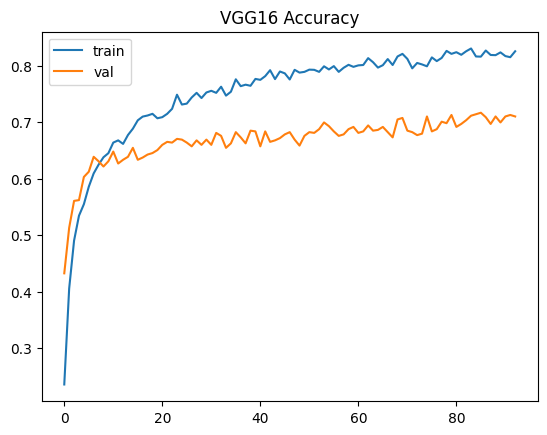

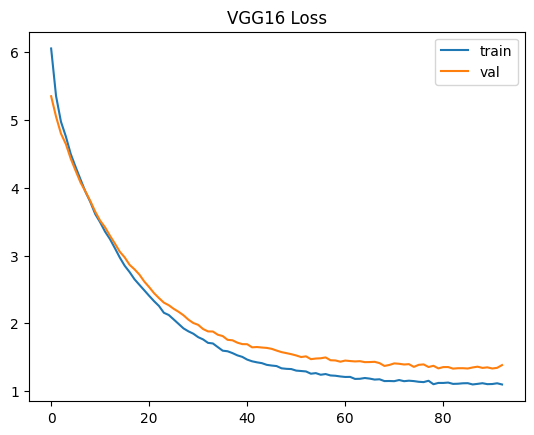

In [28]:
plt.plot(vgg_history.history['accuracy'], label='train')
plt.plot(vgg_history.history['val_accuracy'], label='val')
plt.title('VGG16 Accuracy')
plt.legend()
plt.show()

plt.plot(vgg_history.history['loss'], label='train')
plt.plot(vgg_history.history['val_loss'], label='val')
plt.title('VGG16 Loss')
plt.legend()
plt.show()

In [29]:
# Train set evaluations
train_eval_flow_vgg = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_eval_flow_vgg.reset()
true_labels_vgg = train_eval_flow_vgg.classes
predicted_probs_vgg = vgg_model.predict(train_eval_flow_vgg, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)

print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=train_eval_flow_vgg.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

Found 3042 images belonging to 9 classes.
381/381 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.99      0.96      0.98       295
      2-Food Organics       0.96      0.98      0.97       263
              3-Glass       0.98      0.93      0.95       269
              4-Metal       0.95      0.95      0.95       506
5-Miscellaneous Trash       0.93      0.90      0.92       317
              6-Paper       0.94      0.97      0.96       320
            7-Plastic       0.92      0.96      0.94       589
      8-Textile Trash       0.94      0.93      0.93       204
         9-Vegetation       0.97      0.97      0.97       279

             accuracy                           0.95      3042
            macro avg       0.95      0.95      0.95      3042
         weighted avg       0.95      0.95      0.95      3042

Train F1: 0.9516 | Precision: 0.9544 | Recall: 0.9492 | AUC: 0.9985


In [30]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_vgg = aug_val_flow.classes
predicted_probs_vgg = vgg_model.predict(aug_val_flow, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)

print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=aug_val_flow.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.09      0.07      0.08        73
      2-Food Organics       0.03      0.03      0.03        65
              3-Glass       0.03      0.03      0.03        67
              4-Metal       0.14      0.15      0.15       126
5-Miscellaneous Trash       0.16      0.16      0.16        79
              6-Paper       0.17      0.15      0.16        80
            7-Plastic       0.16      0.17      0.17       147
      8-Textile Trash       0.15      0.18      0.16        50
         9-Vegetation       0.12      0.13      0.13        69

             accuracy                           0.13       756
            macro avg       0.12      0.12      0.12       756
         weighted avg       0.13      0.13      0.13       756

Val F1: 0.1182 | Precision: 0.1180 | Recall: 0.1194 | AUC: 0.5035


In [31]:
# Test set evaluations
res_eval.reset()
true_labels_vgg = res_eval.classes
predicted_probs_vgg = vgg_model.predict(res_eval, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)
print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=res_eval.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.85      0.78      0.82        93
      2-Food Organics       0.90      0.88      0.89        83
              3-Glass       0.88      0.83      0.85        84
              4-Metal       0.81      0.85      0.83       158
5-Miscellaneous Trash       0.79      0.69      0.74        99
              6-Paper       0.87      0.85      0.86       100
            7-Plastic       0.78      0.85      0.82       185
      8-Textile Trash       0.82      0.80      0.81        64
         9-Vegetation       0.91      0.97      0.94        88

             accuracy                           0.84       954
            macro avg       0.85      0.83      0.84       954
         weighted avg       0.84      0.84      0.83       954

F1: 0.8384 | Precision: 0.8455 | Recall: 0.8333 | AUC: 0.9834


In [32]:
# Comparison summary
acc_resnet50 = np.mean(predicted_labels == true_labels)
acc_resnet101 = np.mean(predicted_labels_101 == true_labels_101)
acc_efficientnet = np.mean(predicted_labels_eff == true_labels_eff)
acc_vgg16 = np.mean(predicted_labels_vgg == true_labels_vgg)

summary_df = pd.DataFrame({
    'Model': ['ResNet50', 'ResNet101', 'EfficientNetB0', 'VGG16'],
    'Accuracy': [acc_resnet50, acc_resnet101, acc_efficientnet, acc_vgg16],
    'Precision': [macro_prec, macro_prec_101, macro_prec_eff, macro_prec_vgg],
    'Recall': [macro_recall, macro_recall_101, macro_recall_eff, macro_recall_vgg],
    'F1 Score': [macro_f1, macro_f1_101, macro_f1_eff, macro_f1_vgg],
    'AUC': [macro_auc, macro_auc_101, macro_auc_eff, macro_auc_vgg]
}).round(4).set_index('Model')

summary_df

,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
ResNet50,0.8585,0.8650,0.8675,0.8645,0.9896
ResNet101,0.8711,0.8768,0.8795,0.8768,0.9883
EfficientNetB0,0.7987,0.8054,0.8085,0.8055,0.9775
VGG16,0.8354,0.8455,0.8333,0.8384,0.9834


I evaluated the performance of four pre-trained convolutional neural networks—ResNet50, ResNet101, EfficientNetB0, and VGG16—on a multi-class waste classification task using frozen feature extractors and custom classification heads. Among them, ResNet101 achieved the highest performance, with a test accuracy of 87.11% and an AUC of 0.9883, showing consistently strong precision, recall, and F1 scores. ResNet50 closely followed, with slightly lower accuracy but the highest AUC at 0.9896. VGG16 also performed well, reaching 83.54% accuracy and an AUC of 0.9834, while EfficientNetB0 showed stable results at 79.87% accuracy and an AUC of 0.9775. Applying model-specific preprocessing, label smoothing, and dropout-based regularization contributed significantly to these improvements. Overall, the results highlight the impact of architecture and optimization choices, and suggest that further gains could be achieved by unfreezing deeper layers or tuning learning rates more aggressively.